In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st 
import math
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect

In [86]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution of an european put option of a geometric brownian motion with equidistant time steps adjusted to the market price
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    I_market : float
        Market price of such put options
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Mark to market price of the put option"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0, sigma,r,T, m, N):
    """This function generates a geometric brownian motion with time steps of size T/m

    Parameters
    ----------
    S_0 : float
        Initial value of the geometric brownian motion
    sigma : float
        volatility of the geometric brownian motion
    r : float
        interest rate of the geometric brownian motion
    T : float
        time horizon of the geometric brownian motion
    m : int
        time steps of the brownian motion

    Returns
    -------
    S : np.ndarray
        GBM evaluated at time (T/m,2T/m,...,T) (m_features,) """
    
    if m == 1:
        W_T = st.norm.rvs(loc=0, scale=np.sqrt(T), size=N)
        return S_0 * np.exp((r - sigma**2 / 2) * T + sigma * W_T)
    
    simulations = np.ndarray((N,m+1))
    for j in range(N):
        W = np.zeros(m+1)
        for i in range(1,m+1):
            delta = st.norm.rvs(loc=0, scale=np.sqrt(T/m))
            W[i] = W[i-1] + delta
        S = np.zeros(m+1)
        S[0] = S_0
        S[1:] = S_0 * np.exp((r - sigma**2 / 2) * np.arange(1,m+1)*T/m + sigma * W[1:])
        simulations[j] = S
    return simulations

def J_estimator_European(sigma, N, K = 120, S0 = 100, r = 0.05, T = 0.2, I_market = 22, m=1):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    S_T = Simulate_Stock_Price(S0, sigma, r, T, m, N=N)
    J = np.exp(-r*T) * (K - S_T)
    J[J < 0] = 0
    return np.mean(J) - I_market

def RM(func, n, N, rho, sigma_0, alpha_0, K, S0, T, r, I_market, m, r_tilde=None):
    """ Implementation of the Robbins-Monro algorithm for the root finding problem

    Parameters
    ----------
    func : function
        function for which we want to find the root
    n : int
        number of iterations of the RM alogrithn
    N : int
        Size of the sample size for the estimation of the expected value of the stock price in I(sigma) 
    rho : float
        order convergence of the sequence alpha_n
    iterations: int
        number of iterations to compute the expectation of the MSE
    Returns
    -------
    sigma_estim : float
        Estimation of the volatility of the geometric brownian motion at iteration n"""
    i = 0
    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    while True:
        alpha_n = alpha_0 / i**rho if i > 0 else alpha_0
        sigma_cur = sigma_estim[i]
        if r_tilde:
            sigma_estim[i+1] = sigma_cur - alpha_n * func(sigma_cur, N, K=K, S0=S0, r=r, T=T, I_market=I_market, r_tilde=r_tilde, m=m)
        else:
            sigma_estim[i+1] = sigma_cur - alpha_n * func(sigma_cur, N, K=K, S0=S0, r=r, T=T, I_market=I_market, m=m)
        i+=1
        if i == n-1:
            break
    return sigma_estim

Calculate the 'true' implied volatility

In [7]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)

0.508372926009589


Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

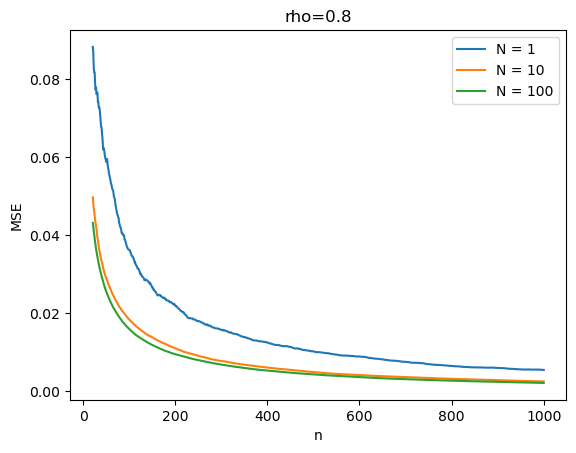

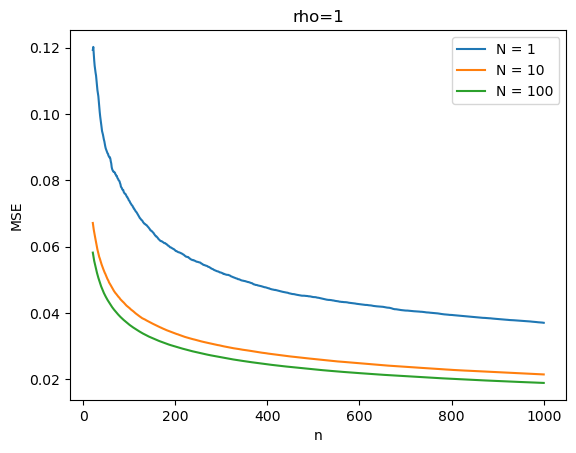

In [24]:
n = 1000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
for rho in [0.8,1]:
    plt.figure()
    plt.title('rho=' + str(rho))
    for N in [1,10,100]:
        # Estimate expectation of MSE
        all_sigma_estim = np.empty((iterations,), dtype=np.ndarray)
        for i in range(iterations):
            all_sigma_estim[i] = RM(J_estimator_European, n, N, rho, sigma_0=1, alpha_0=2/(K+S0), K=K, S0=S0, T=T, r=r, I_market=I_market, m=1)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        plt.plot(np.arange(21, n+1), MSE[20:], label='N = ' + str(N))
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('MSE')

RM Algorithm to find implied volatility for Asian put option with I_market = 22

In [181]:
def J_estimator_Asian(sigma, N, K = 120, S0 = 100, r = 0.05, T = 0.2, I_market = 22, m = 30):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    m : int
        number of time steps
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    if m == 1:
        all_S = np.array([np.array([S0, S]) for S in Simulate_Stock_Price(S0, sigma, r, T, m, N)])
    else:
        all_S = Simulate_Stock_Price(S0, sigma, r, T, m, N)

    S_avg = np.mean(all_S[:, 1:], axis=1)
    J = np.exp(-r*T) * (K - S_avg)
    J[J < 0] = 0
    return np.mean(J) - I_market

Text(0, 0.5, 'sigma')

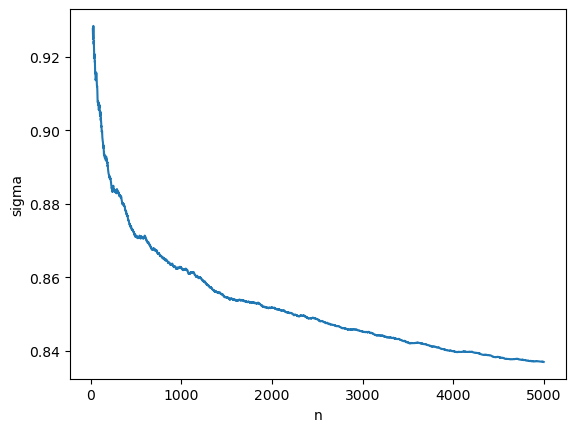

In [38]:
n=5000
N=100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigmas = RM(J_estimator_Asian, n, N, rho=0.8, sigma_0=1, alpha_0=2/(K+S0), K=K, S0=S0, T=T, r=r, I_market=I_market, m=30, r_tilde=None)
plt.plot(range(21,n+1), sigmas[20:])
plt.xlabel('n')
plt.ylabel('sigma')

In [ ]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

In [182]:
# Question 6: Important Sampling

# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = I(sigma) - I_market

# Calculate likelihood ratio
def w(S, sigma, r, r_tilde, T):
    return np.prod(S[1:]/S[:-1])**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))


def J_estimator_Asian_IS(sigma, N, K = 80, S0 = 100, r = 0.05, r_tilde=0.01, T = 0.2, I_market = 22, m = 30):
    if m == 1:
        all_S = np.array([np.array([S0, S]) for S in Simulate_Stock_Price(S0, sigma, r_tilde, T, m, N)])
    else:
        all_S = Simulate_Stock_Price(S0, sigma, r_tilde, T, m, N)
    likelihood_ratios = [w(S,sigma,r,r_tilde,T) for S in all_S]

    S_avg = np.mean(all_S[:, 1:], axis=1)
    J = np.exp(-r*T) * (K - S_avg)
    J[J < 0] = 0

    J = np.multiply(J, likelihood_ratios)
    return np.mean(J) - I_market

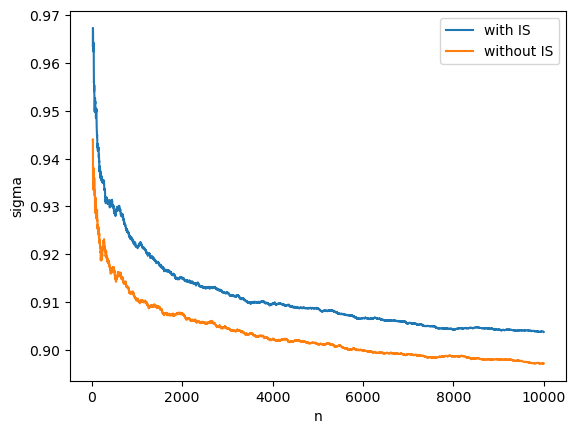

In [189]:
n=10000
N=10

K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 2

r_tilde = 0.001
m = 10

sigmas_IS = RM(J_estimator_Asian_IS, n, N, rho=0.8, sigma_0=1, alpha_0=2/(K+S0), K=K, S0=S0, T=T, r=r, I_market=I_market, r_tilde=r_tilde, m=m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM(J_estimator_Asian, n, N, rho=0.8, sigma_0=1, alpha_0=2/(K+S0), K=K, S0=S0, T=T, r=r, I_market=I_market, m=m)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()